# 確率的勾配降下法などを用いたNNの計算

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonフォルダの中身を全て選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')

from common.network import TwoLayerNet

ローカル環境での実行です


In [2]:
class SGD:
    def __init__(self, lr=0.01):
        """
        lr : 学習係数 learning rate
        """
        self.lr = lr
        
    def update(self, params, grads):
        """
        重みの更新
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
class RMSProp:
    """
    RMSProp
    """
    def __init__(self, lr=0.01, rho=0.9):
        """
        lr : 学習係数 learning rate
        rho : 減衰率
        """
        self.lr = lr
        self.h = None
        self.rho = rho
        self.epsilon = 1e-6
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] = self.rho * self.h[key] + (1 - self.rho) * grads[key] * grads[key]          
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + self.epsilon) ) # 原著論文に合わせてepsilonをルートの中に入れる            

In [3]:
# !pip install tensorflow

In [4]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

train = X_train/255
test = X_test/255
train = train.reshape(-1, 28*28)
test = test.reshape(-1, 28*28)
train_labels = lb.fit_transform(y_train)
test_labels = lb.fit_transform(y_test)

x_train, t_train = train, train_labels
x_test, t_test = test, test_labels

2022-09-15 19:05:59.938150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 19:06:00.860721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 19:06:00.860771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-15 19:06:01.117780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 19:06:03.316402: W tensorflow/stream_executor/platform/de

### [演習]
* 以下の処理を完成させましょう


In [19]:
x = train[:1000,:]
t = train_labels[:1000,:]

epochs = 50
batch_size = 25

def run(optimizer):
    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    # 2層NNのオブジェクト生成
    tnet = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    
    np.random.seed(1234)
    # Numpy.random.randint(最小、最大、サイズ)：最小値以上、最大値未満の乱数を生成
    # 0〜48の一様分布になっている。randint(0, epochs, epochs-1)が正しい？？ 
    # https://note.nkmk.me/python-numpy-random/
    seeds = np.random.randint(0, epochs-1, epochs)
    print(seeds)
    
    for epoch in range(epochs):
        # epoch = 0, ..., epochs-1を次々代入
        # print("epoch=%s"%epoch)

        # シャッフル
        # 0, ..., xsize-1の配列を生成
        idx = np.arange(xsize)
        np.random.seed(seeds[epoch])
        # idxのリストをランダムに並び替える
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]

            # 勾配の計算 (誤差逆伝播法を用いる) 
            grads = tnet.gradient(x_train, t_train)

            # 更新
            # def update(self, params, grads):
            optimizer.update(tnet.params, grads)

        ## 学習経過の記録

        # 訓練データにおけるloss
        train_loss.append(tnet.loss(x,  t))

        # テストデータにおけるloss
        test_loss.append(tnet.loss(test, test_labels))

        # 訓練データにて精度を確認
        train_accuracy.append(tnet.accuracy(x, t))

        # テストデータにて精度を算出
        test_accuracy.append(tnet.accuracy(test, test_labels))
        

    # lossのグラフ化
    df_log = pd.DataFrame({"train_loss":train_loss,
                 "test_loss":test_loss,
                 "train_accuracy":train_accuracy,
                 "test_accuracy":test_accuracy})
    df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
    plt.ylim([0,3])
    plt.ylabel("Accuracy or loss")
    plt.xlabel("epochs")
    plt.show()
    print(df_log)
    
    return 

In [18]:
xsize = 20
epochs = 10
seeds = np.random.randint(0, epochs-1, epochs)
batch_size = 5
it = 2
for epoch in range(epochs):
    idx = np.arange(xsize)
    np.random.seed(seeds[epoch])
    np.random.shuffle(idx)
    print(idx)
    print(seeds[epoch])
    print(np.random.seed(seeds[epoch]))
    # 上記により乱数シードを固定
    # リストの要素をシャッフル（https://note.nkmk.me/python-random-shuffle/）
    print(np.random.shuffle(idx))
    # 上記によりidxの要素をシャッフル
    print(idx)
    mask = idx[batch_size*it : batch_size*(it+1)]
    print(mask)
    print('***')


[ 7 11  6 15 18  4 12  2 13  1 16  0 14 19  8 10  5  9 17  3]
8
None
None
[ 2  0 12 10 17 18 14  6 19 11  5  7  8  3 13 16  4  1  9 15]
[ 5  7  8  3 13]
***
[ 3 16  6 10  2 14  4 17  7  1 13  0 19 18  9 15  8 12 11  5]
1
None
None
[10  8  4 13  6  9  2 12 17 16 18  3  5 11  1 15  7 19  0 14]
[18  3  5 11  1]
***
[17  7  5  6  8  2 15 14  4 11 12  1 18  0 16 13 19  3  9 10]
6
None
None
[ 3 14  2 15  4  5 13 16  8  1 18  7  9 17 19  0 10  6 11 12]
[18  7  9 17 19]
***
[12  4 18  0  9  5  3 10  1 17  7 16 14  2 11  6 19 13 15  8]
2
None
None
[14  9 15 12 17  5  0  7  4 13 10 19 11 18 16  3  8  2  6  1]
[10 19 11 18 16]
***
[12  4 18  0  9  5  3 10  1 17  7 16 14  2 11  6 19 13 15  8]
2
None
None
[14  9 15 12 17  5  0  7  4 13 10 19 11 18 16  3  8  2  6  1]
[10 19 11 18 16]
***
[ 3 16  6 10  2 14  4 17  7  1 13  0 19 18  9 15  8 12 11  5]
1
None
None
[10  8  4 13  6  9  2 12 17 16 18  3  5 11  1 15  7 19  0 14]
[18  3  5 11  1]
***
[14  2  1 17  4 16  6  7 15 12  9 11 19 18 13  5  0  8  3 

SGD, lr=0.01
[47 19 38 12 24 15 23 41 26 30 43 30 44 26 48 28  5 16  9 47 48 12 37 34
 38  3 39 11  0 41 11 16  3  2 19 12  1 11 43 17 14  7 42 43 46 28 17 23
 13 32]


/tmp/ipykernel_1019/3113304752.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


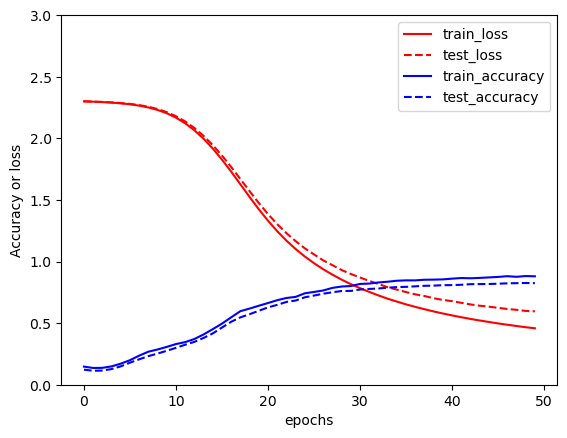

    train_loss  test_loss  train_accuracy  test_accuracy
0     2.299848   2.300346           0.147         0.1223
1     2.297235   2.298169           0.136         0.1131
2     2.293968   2.295377           0.137         0.1149
3     2.289694   2.291640           0.149         0.1271
4     2.283948   2.286534           0.171         0.1490
5     2.276091   2.279474           0.199         0.1791
6     2.265337   2.269710           0.236         0.2062
7     2.250580   2.256206           0.268         0.2320
8     2.230444   2.237697           0.286         0.2527
9     2.203373   2.212655           0.307         0.2754
10    2.167754   2.179597           0.330         0.2993
11    2.122025   2.137057           0.346         0.3247
12    2.065081   2.084050           0.371         0.3477
13    1.996554   2.019975           0.408         0.3796
14    1.916927   1.944689           0.451         0.4164
15    1.827215   1.860027           0.496         0.4639
16    1.729450   1.767164      

/tmp/ipykernel_1019/3113304752.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


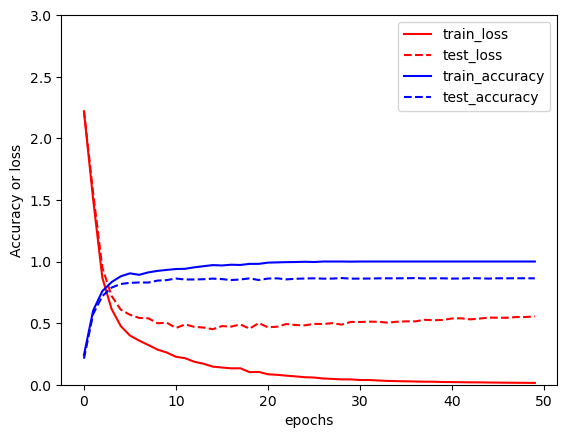

    train_loss  test_loss  train_accuracy  test_accuracy
0     2.217339   2.226444           0.241         0.2115
1     1.505716   1.555023           0.602         0.5738
2     0.868271   0.949864           0.760         0.7195
3     0.615055   0.721581           0.833         0.7883
4     0.476035   0.609417           0.880         0.8176
5     0.399296   0.567743           0.904         0.8269
6     0.358003   0.542181           0.892         0.8300
7     0.322262   0.539144           0.912         0.8293
8     0.285107   0.498753           0.924         0.8453
9     0.261266   0.503575           0.932         0.8492
10    0.226856   0.460761           0.939         0.8621
11    0.215074   0.489453           0.941         0.8541
12    0.186104   0.469557           0.953         0.8543
13    0.170217   0.463984           0.962         0.8564
14    0.146884   0.450525           0.971         0.8612
15    0.139736   0.475980           0.968         0.8573
16    0.132925   0.471806      

/tmp/ipykernel_1019/3113304752.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


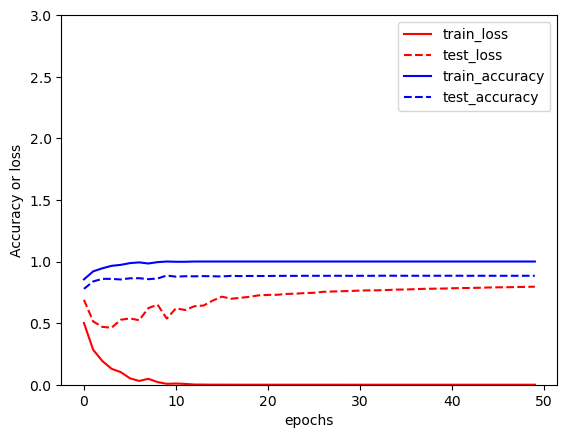

    train_loss  test_loss  train_accuracy  test_accuracy
0     0.500874   0.689360           0.855         0.7780
1     0.283924   0.513710           0.920         0.8383
2     0.192020   0.469310           0.945         0.8594
3     0.129346   0.462724           0.965         0.8591
4     0.102243   0.527311           0.973         0.8543
5     0.051963   0.538535           0.987         0.8640
6     0.030614   0.523353           0.993         0.8646
7     0.047976   0.621836           0.984         0.8568
8     0.021306   0.649401           0.995         0.8622
9     0.007344   0.536905           1.000         0.8865
10    0.009563   0.620469           0.998         0.8771
11    0.006609   0.606331           0.998         0.8806
12    0.001627   0.637033           1.000         0.8798
13    0.001269   0.642952           1.000         0.8817
14    0.000417   0.683383           1.000         0.8802
15    0.000576   0.714889           1.000         0.8789
16    0.000225   0.697839      

In [20]:
# 計算実行部分
# 完成したら最適化手法をいろいろ変えてみる

for  i in range(3):
    
    if i==0:
        print("SGD, lr=0.01")
        optimizer = SGD(lr=0.01)
        run(optimizer)
    elif i==1:
        print("SGD, lr=0.1")        
        optimizer = SGD(lr=0.1)
        run(optimizer)        
    elif i==2:
        print("RMSProp, lr=0.01, rho=0.9")        
        optimizer = RMSProp(lr=0.01, rho=0.9)
        run(optimizer)

### [演習]
* 最適化手法を変更し、結果がどのように変わるかを確認しましょう